In [1]:
import os
import numpy as np
import json
import cv2
import random
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor


## Register dataset

In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog
# for d in ["train", "val"]:
for d in ["train", "val"]:
    register_coco_instances("ucb_gait_{}".format(d), {}, 
                            "/home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_{}.json".format(d),
                            "/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images")
                            # "/home/josmar/proyectos/codes/datasets/lvis/lvis_v1_{}_cocofied.json".format(d),
                            # "/home/josmar/proyectos/codes/datasets/coco/train2017")

                            # "/home/josmar/proyectos/codes/datasets/ochumans/ochuman_coco_format_{}_range_0.00_1.00.json".format(d),
                            # "/home/josmar/proyectos/codes/datasets/ochumans/images")
    MetadataCatalog.get("ucb_gait_" + d).set(thing_classes=["person"])
ucb_gait_metadata = MetadataCatalog.get("ucb_gait_train")
print(ucb_gait_metadata)

Metadata(evaluator_type='coco', image_root='/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images', json_file='/home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_train.json', name='ucb_gait_train', thing_classes=['person'])


In [3]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get("ucb_gait_train")


/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images/045-275.jpg


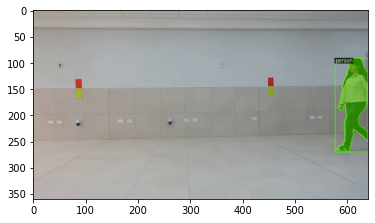

/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images/015-136.jpg


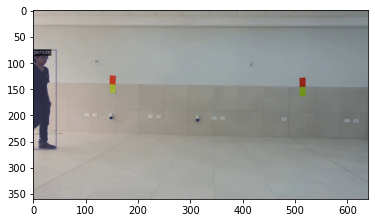

/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images/005-121.jpg


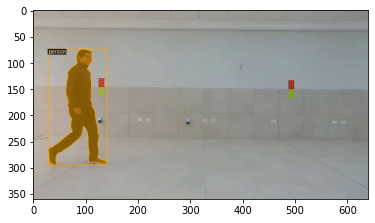

In [4]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ucb_gait_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.imshow(vis.get_image())
    plt.show()

## Training

In [5]:
import sys
sys.path.append('/home/josmar/proyectos/centermask2')

from detectron2.engine import DefaultTrainer
from centermask.config import get_cfg
from detectron2.engine import  default_setup
from train_net import Trainer
import torch

cfg = get_cfg()
cfg.merge_from_file("/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_19_eSE_FPN_ms_4x.yaml")
cfg.DATASETS.TRAIN = ("ucb_gait_train",)

cfg.DATASETS.TEST = ("ucb_gait_train",)  # no metrics implemented for this dataset
cfg.TEST.EVAL_PERIOD = 100

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/home/josmar/proyectos/centermask2/weights/centermask2-lite-V-19-eSE-FPN-ms-4x.pth"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.FCOS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.FCOS.NUM_CLASSES = 1  # only has one class (ballon)



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Config '/home/josmar/proyectos/centermask2/configs/centermask/centermask_lite_V_19_eSE_FPN_ms_4x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/18 21:28:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): VoVNet(
      (stem): Sequential(
        (stem_1/conv): Conv2d

In [6]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir="/home/josmar/proyectos/codes/02_detectron2_notebooks/P3_centermask_silhouettes/output"

## Prediction

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.FCOS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.FCOS.INFERENCE_TH_TEST = 0.7
cfg.DATASETS.TEST = ("ucb_gait_val", )
predictor = DefaultPredictor(cfg)

[11/18 21:29:43 d2.data.datasets.coco]: Loaded 1230 images in COCO format from /home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_val.json


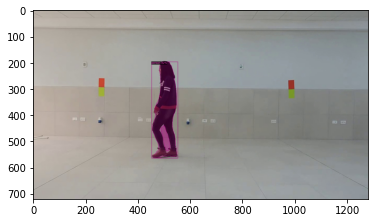

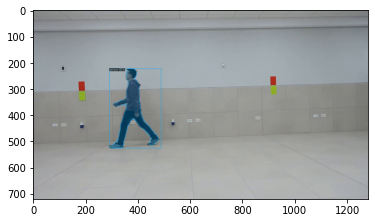

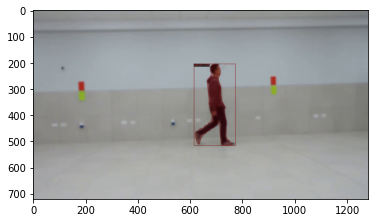

In [8]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("ucb_gait_val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ucb_gait_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.imshow(out.get_image())
    plt.show()

## Evaluate

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("ucb_gait_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ucb_gait_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [11/18 21:29:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[11/18 21:29:46 d2.data.datasets.coco]: Loaded 1230 images in COCO format from /home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_val.json
[11/18 21:29:46 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 1230         |
|            |              |
[11/18 21:29:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(600, 600), max_size=1000, sample_style='choice')]
[11/18 21:29:46 d2.data.common]: Serializing 1230 elements to byte tensors and concatenating them all ...
[11/18 21:29:46 d2.data.common]: Serialized dataset takes 29.74 MiB
[11/18 21:29:46 d2.evaluation.evaluator]: Start inference on 1230 images
[11/18 21:29:47 d2.evaluation.evaluator]: Inference 

OrderedDict([('bbox',
              {'AP': 91.81690545773444,
               'AP50': 98.6213257868159,
               'AP75': 98.00781277165932,
               'APs': 14.587458745874587,
               'APm': 56.27720533502806,
               'APl': 92.84308529603244}),
             ('segm',
              {'AP': 84.78712920744327,
               'AP50': 98.74431731194878,
               'AP75': 97.59869720654194,
               'APs': 19.140426699359406,
               'APm': 37.30602445106587,
               'APl': 86.13427816029369})])